# Analyzing a Transmon + Cavity System

Today, I'll be showing you how to compare a Transmon & Cavity simulation to experimental data using the default renderers on `Qiskit-Metal`. Our process is as follows:

1. Retrieve experimental `Lj_exp` value corresponding to the design device
2. Create design using Qiskit Metal
3. Extract eigenfrequencies & anharmonicity from `qiskit_metal.<...>.EPRanalysis` through eigenmodal simulation
4. Extract capacitance matrix from `qiskit_metal.<...>.LOManalysis`
5. Use qubit frequency, cavity frequency, anharmonicity, and capacitance matricies to calculate $g$ and $\chi$

## Step 1. Experimental $L_J$

In [1]:
import numpy as np

def find_Lj_from_qubitfreq_anharm(qubit_freq: float, qubit_anharmonicity: float) -> float:
    """
    Extract $L_J$ from the qubit frequency & anharmonicity.

    Args:
        qubit_freq: Transition frequenc from ground to first excited state. Units are linear GHz.
        Qubit_anharmonicity: Qubit anharmonicity. Units are linear GHz.

    Returns:
        LJ: Units are Nano-Henries.
    """
    import scqubits as scq
    from scqubits.core.transmon import TunableTransmon

    scq.set_units("GHz")

    Phi_0 = 2.067833848E-15
    h = 6.62607015E-34

    EJ, EC = TunableTransmon.find_EJ_EC(E01=qubit_freq, anharmonicity=qubit_anharmonicity, ncut=30)
    LJ = (Phi_0/ (2 * np.pi))**2 / (EJ * h)

    print('From scQubits')
    print(f"E_J = {EJ:0.3f} Linear GHz")
    print(f"L_J = {LJ:0.3f} nH")

    return LJ

In [2]:
exp_qubit_freq          =  3.715 # GHz
exp_qubit_anharmonicity = -0.150 # GHz # Don't forget the negative sign!

Lj_exp = find_Lj_from_qubitfreq_anharm(
    qubit_freq=exp_qubit_freq, 
    qubit_anharmonicity=exp_qubit_anharmonicity
)  # nH

From scQubits
E_J = 13.588 Linear GHz
L_J = 12.030 nH


You'll take this experimental $L_J$ and put it into your Qiskit Metal design. Specifically in...

```
design.components[<qubit name>].options.hfss_inductance = str(Lj_exp) + "nH"
design.components[<qubit name>].options.q3d_inductance  = str(Lj_exp) + "nH"
```

Remeber the inductance options want a value which looks similar to...
- `"9nH"`
- `"9 nH"`
- `"9.123nH"`
- `"9.123 nH`
- etc.


## Step 2. Create Design in Qiskit Metal

Here I outline a simple Transmon Cross coupled to readout cavity

In [3]:
qubit_name = 'qubit'
connection_pad_name = 'readout'
cavity_name = 'cavity'
feedline_name = 'clt'

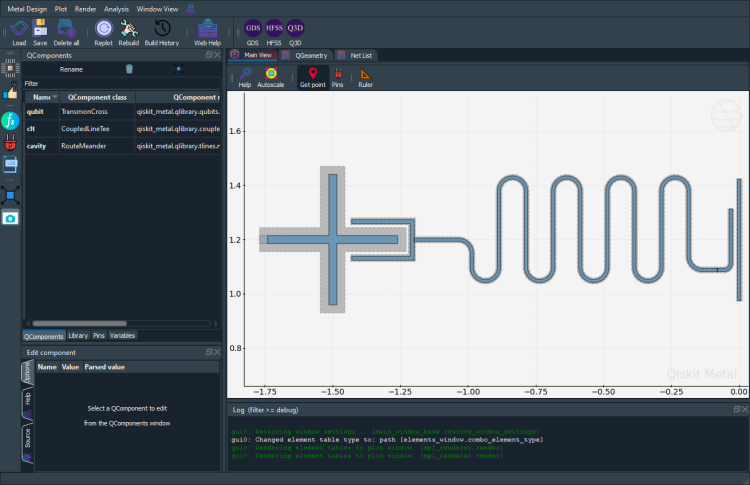

In [4]:
%load_ext autoreload
%autoreload 2
from qiskit_metal import draw, Dict, designs, MetalGUI
from qiskit_metal.toolbox_metal import math_and_overrides
from qiskit_metal.qlibrary.core import QComponent
import qiskit_metal as metal
# ?metal.qlibrary.core.QComponent.add_qgeometry

design = metal.designs.design_planar.DesignPlanar()
gui = metal.MetalGUI(design)
design.overwrite_enabled = True

# dir(QComponent)
cpw_width = '11.7um'

design._chips.main.size.size_x = '5mm'
design._chips.main.size.size_y = '5mm'
from qiskit_metal.qlibrary.terminations.launchpad_wb import LaunchpadWirebond
from qiskit_metal.qlibrary.terminations.short_to_ground import ShortToGround
from qiskit_metal.qlibrary.tlines.straight_path import RouteStraight
from qiskit_metal.qlibrary.tlines.anchored_path import RouteAnchors
from qiskit_metal.qlibrary.tlines.mixed_path import RouteMixed
from qiskit_metal.qlibrary.qubits.transmon_cross import TransmonCross
from qiskit_metal.qlibrary.tlines.meandered import RouteMeander
from qiskit_metal.qlibrary.terminations.open_to_ground import OpenToGround
from qiskit_metal.qlibrary.couplers.coupled_line_tee import CoupledLineTee
from qiskit_metal.qlibrary.couplers.cap_n_interdigital_tee import CapNInterdigitalTee
from qiskit_metal.qlibrary.couplers.line_tee import LineTee

from collections import OrderedDict

import numpy as np
xmon1_options = dict(
    connection_pads={
        connection_pad_name : dict(
            connector_location = '90', 
            connector_type = '0', 
            claw_length = '215um',
            ground_spacing = '10um', 
            claw_gap = '5.1um', 
            claw_width = '15um',
            claw_cpw_length = 0
        ),
    },
    cross_width = '30um',
    cross_length = '240um',
    cross_gap = '30um',
    orientation = '-90',
    pos_x = '-1500um',
    pos_y = '1200um',
    aedt_hfss_inductance = 10.60932E-9
)

# Create a new Transmon Cross object with name 'Q1'
q1 = TransmonCross(design, qubit_name, options=xmon1_options)

clt1_opts = Dict(prime_width = cpw_width,
                prime_gap = '5.1um',
                second_width = cpw_width,
                second_gap = '5.1um',
                coupling_space = '7.9um',
                coupling_length = '225um',
                open_termination = False,
                orientation = '-90',
                pos_y = '1200um',
                down_length = '50um')

clt1 = CoupledLineTee(design, feedline_name, clt1_opts)

cpw_total_length = 5160 + 716 + 300 + 1881.18568
cpw_total_length = str(cpw_total_length) + 'um'
cpw1_opts = Dict(pin_inputs = Dict(start_pin = Dict(component = feedline_name,
                                                    pin = 'second_end'),
                                   end_pin = Dict(component = qubit_name,
                                                  pin = connection_pad_name)),
                lead = Dict(end_straight = '70um',
                            # start_jogged_extension = jogsS),
                ),
                fillet = '49.9um',
                total_length = '3900um',#'3893.8166um', # '6776um',
                trace_width = cpw_width,
                meander = Dict(spacing = '100um',
                               asymmetry = '-150um'),
                trace_gap = '5.1um',)
cpw1 = RouteMeander(design, cavity_name, options = cpw1_opts)

gui.rebuild()
gui.zoom_on_components([qubit_name, cavity_name, feedline_name])
gui.screenshot()

# 3. Using `AnsysQiskitMetal`

In [5]:
from ansys_qiskitmetal import AnsysQiskitMetal

ansys = AnsysQiskitMetal(
    design,
    qubit_name=qubit_name,
    connection_pad_name=connection_pad_name,
    cpws_names=[cavity_name],
    feedline_name=feedline_name
)

## Simulations

### Run ANSYS -> HFSS -> Eigenmode Simulation to get the Classical Mode Frequencies.

In [6]:
# Runs simulation where the Josephson Junction inductance is...
design.components[qubit_name].options['hfss_inductance']

'10nH'

In [7]:
ansys.run_EigenModes(max_passes = 1)

INFO 12:27PM [connect_project]: Connecting to Ansys Desktop API...
INFO 12:27PM [load_ansys_project]: 	Opened Ansys App
INFO 12:27PM [load_ansys_project]: 	Opened Ansys Desktop v2021.1.0
INFO 12:27PM [load_ansys_project]: 	Opened Ansys Project
	Folder:    D:/lfl/Documents/Ansoft/
	Project:   Project18
INFO 12:27PM [connect_design]: No active design found (or error getting active design).
INFO 12:27PM [connect]: 	 Connected to project "Project18". No design detected
12:27PM 45s WARNING [activate_ansys_design]: The design_name=QubitCavity_eigenmode20230805_1227 was not in active project.  Designs in active project are: 
[].  A new design will be added to the project.  
INFO 12:27PM [connect_design]: 	Opened active design
	Design:    QubitCavity_eigenmode20230805_1227 [Solution type: Eigenmode]
WARNING 12:27PM [connect_setup]: 	No design setup detected.
WARNING 12:27PM [connect_setup]: 	Creating eigenmode default setup.
INFO 12:27PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys

pyaedt INFO: using existing logger.


INFO:Global:using existing logger.


pyaedt INFO: Launching PyAEDT outside AEDT with CPython and PythonNET.


INFO:Global:Launching PyAEDT outside AEDT with CPython and PythonNET.


pyaedt INFO: AEDT installation Path D:\Program Files\ANSYS\AnsysEM21.1\Win64.


INFO:Global:AEDT installation Path D:\Program Files\ANSYS\AnsysEM21.1\Win64.


pyaedt INFO: Launching AEDT with module PythonNET.


INFO:Global:Launching AEDT with module PythonNET.


pyaedt WARNING: PyAEDT is not supported in AEDT versions earlier than 2021 R2. Trying to launch PyAEDT with PyWin32.


pyaedt INFO: pyaedt v0.6.46


INFO:Global:pyaedt v0.6.46


pyaedt INFO: Python version 3.10.8 | packaged by conda-forge | (main, Nov 22 2022, 08:16:53) [MSC v.1929 64 bit (AMD64)]


INFO:Global:Python version 3.10.8 | packaged by conda-forge | (main, Nov 22 2022, 08:16:53) [MSC v.1929 64 bit (AMD64)]


pyaedt INFO: Project Project18 set to active.


INFO:Global:Project Project18 set to active.


pyaedt INFO: Aedt Objects initialized


INFO:Global:Aedt Objects initialized


pyaedt INFO: Variable Manager initialized


INFO:Global:Variable Manager initialized


pyaedt INFO: Design Loaded


INFO:Global:Design Loaded


pyaedt INFO: Successfully loaded project materials !


INFO:Global:Successfully loaded project materials !


pyaedt INFO: Materials Loaded


INFO:Global:Materials Loaded


pyaedt INFO: Project files removed from handlers.


INFO:Global:Project files removed from handlers.
INFO 12:28PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 12:28PM [analyze]: Analyzing setup Setup


### Run Energy Participation Ratio Analysis on Eigenmode Simulation

In [9]:
ansys.run_EPR()
epr_results = ansys._parse_EPR()

INFO 12:34PM [connect_project]: Connecting to Ansys Desktop API...
INFO 12:34PM [load_ansys_project]: 	Opened Ansys App
INFO 12:34PM [load_ansys_project]: 	Opened Ansys Desktop v2021.1.0
INFO 12:34PM [load_ansys_project]: 	Opened Ansys Project
	Folder:    D:/lfl/Documents/Ansoft/
	Project:   Project18
INFO 12:34PM [connect_design]: 	Opened active design
	Design:    QubitCavity_eigenmode20230805_1227 [Solution type: Eigenmode]
INFO 12:34PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 12:34PM [connect]: 	Connected to project "Project18" and design "QubitCavity_eigenmode20230805_1227" 😀 



Design "QubitCavity_eigenmode20230805_1227" info:
	# eigenmodes    2
	# variations    1

            ℰ_elec_all       = 1.1438658842802e-23
            ℰ_elec_substrate = 1.05129401990789e-23
            EPR of substrate = 91.9%

            ℰ_mag    = 1.27212983688162e-25
            

Variation 0  [1/1]

  Mode 0 at 3.89 GHz   [1/2]
    Calculating ℰ_magnetic,ℰ_electric
       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
               98.9%  5.719e-24 6.361e-26

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_0j   sign s_0j    (p_capacitive)
		Energy fraction (Lj over Lj&Cj)= 98.82%
	jj              0.987834  (+)        0.0117902
		(U_tot_cap-U_tot_ind)/mean=0.64%
Calculating Qdielectric_main for mode 0 (0/1)
p_dielectric_main_0 = 0.9190710505099444

  Mode 1 at 6.25 GHz   [2/2]
    Calculating ℰ_magnetic,ℰ_electric
       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
                0.0%  1.223e-24 1.223e-24

    Calculating junct

WARNING 12:34PM [__init__]: <p>Error: <class 'IndexError'></p>



ANALYSIS DONE. Data saved to:

C:\data-pyEPR\Project18\QubitCavity_eigenmode20230805_1227\2023-08-05 12-34-22.npz


	 Differences in variations:



 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Variation 0

Starting the diagonalization
Finished the diagonalization
Pm_norm=
modes
0    1.012921
1    0.876419
dtype: float64

Pm_norm idx =
      jj
0   True
1  False
*** P (participation matrix, not normlz.)
         jj
0  0.976323
1  0.000264

*** S (sign-bit matrix)
   s_jj
0     1
1     1
*** P (participation matrix, normalized.)
      0.99
   0.00026

*** Chi matrix O1 PT (MHz)
    Diag is anharmonicity, off diag is full cross-Kerr.
       113   0.0973
    0.0973 2.09e-05

*** Chi matrix ND (MHz) 
       122   0.0903
    0.0903 1.79e-05

*** Frequencies O1 PT (MHz)
0    3774.877740
1    6253.319233
dtype: float64

*** Frequencies ND (MHz)
0    3771.344943
1    6253.320020
dtype: float64

*** Q_coupling
Empty DataFrame
Columns: []
Index: [0, 1]


#### Mode frequencies (MHz)

###### Numerical diagonalization

Lj,10
0,3771.34
1,6253.32


#### Kerr Non-linear coefficient table (MHz)

###### Numerical diagonalization

0         1
Lj                    
10 0  121.54  9.03e-02
   1    0.09  1.79e-05

INFO 12:34PM [__del__]: Disconnected from Ansys HFSS


KeyError: '1'

In [20]:
ansys.epra.get_chis()

0         1
variation                        
0         0  121.538342  0.090278
          1    0.090278  0.000018

In [21]:
ansys.epra.get_frequencies()

variation,0
0,3771.344943
1,6253.320020


In [22]:
ansys.epra.data

{'project_info': {'pinfo': design_name     QubitCavity_eigenmode20230805_1227
  project_name                             Project18
  project_path              D:/lfl/Documents/Ansoft/
  setup_name                                   Setup
  dtype: object,
  'dissip': dielectrics_bulk       [main]
  dielectric_surfaces      None
  resistive_surfaces       None
  seams                    None
  dtype: object,
  'options': Series([], dtype: float64),
  'junctions':                                    jj
  Cj_variable                        Cj
  Lj_variable                        Lj
  line             JJ_Lj_qubit_rect_jj_
  rect         JJ_rect_Lj_qubit_rect_jj,
  'ports': Empty DataFrame
  Columns: []
  Index: []},
 'results': {'0': {'Pm':          jj
   0  0.976323
   1  0.000264,
   'Pm_cap':          jj
   0  0.011653
   1  0.000008,
   'Sm':    s_jj
   0     1
   1     1,
   'Om':                  0         1
   freq_GHz  3.887979  6.253368,
   'sols':    Qdielectric_main_0  Qdielectric_

### Run ANSYS -> Q3D Simulation to get the Capacitance Matrix

In [25]:
ansys.run_CapMatirx(max_passes = 1)

INFO 01:03PM [connect_project]: Connecting to Ansys Desktop API...
INFO 01:03PM [load_ansys_project]: 	Opened Ansys App
INFO 01:03PM [load_ansys_project]: 	Opened Ansys Desktop v2021.1.0
INFO 01:03PM [load_ansys_project]: 	Opened Ansys Project
	Folder:    D:/lfl/Documents/Ansoft/
	Project:   Project18
INFO 01:03PM [connect_design]: 	Opened active design
	Design:    QubitCavity_q3d20230805_1227 [Solution type: Q3D]
INFO 01:03PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 01:03PM [connect]: 	Connected to project "Project18" and design "QubitCavity_q3d20230805_1227" 😀 

INFO 01:03PM [connect_design]: 	Opened active design
	Design:    QubitCavity_q3d20230805_1227 [Solution type: Q3D]


pyaedt INFO: using existing logger.


INFO:Global:using existing logger.


pyaedt INFO: Launching PyAEDT outside AEDT with CPython and PythonNET.


INFO:Global:Launching PyAEDT outside AEDT with CPython and PythonNET.


pyaedt INFO: AEDT installation Path D:\Program Files\ANSYS\AnsysEM21.1\Win64.


INFO:Global:AEDT installation Path D:\Program Files\ANSYS\AnsysEM21.1\Win64.


pyaedt INFO: Launching AEDT with module PythonNET.


INFO:Global:Launching AEDT with module PythonNET.


pyaedt WARNING: PyAEDT is not supported in AEDT versions earlier than 2021 R2. Trying to launch PyAEDT with PyWin32.


pyaedt INFO: pyaedt v0.6.46


INFO:Global:pyaedt v0.6.46


pyaedt INFO: Python version 3.10.8 | packaged by conda-forge | (main, Nov 22 2022, 08:16:53) [MSC v.1929 64 bit (AMD64)]


INFO:Global:Python version 3.10.8 | packaged by conda-forge | (main, Nov 22 2022, 08:16:53) [MSC v.1929 64 bit (AMD64)]


pyaedt INFO: Project Project18 set to active.


INFO:Global:Project Project18 set to active.


pyaedt INFO: Aedt Objects initialized


INFO:Global:Aedt Objects initialized


pyaedt INFO: Variable Manager initialized


INFO:Global:Variable Manager initialized


pyaedt INFO: Design Loaded


INFO:Global:Design Loaded


pyaedt INFO: Successfully loaded project materials !


INFO:Global:Successfully loaded project materials !


pyaedt INFO: Materials Loaded


INFO:Global:Materials Loaded


AttributeError: GetModule.ListReduceMatrixes

## Parse Results

We can view all the results of the simulation by running `_parse_all_results()`

In [ ]:
ansys._parse_all_results(print_result=True)

We can also view the results by viewing the attributes of `AnsysQiskitMetal`

In [ ]:
print(ansys.qubit_freq)
print(ansys.cavity_freq)
print(ansys.anharmonicity)
print(ansys.dispersive_shift)
print(ansys.coupling_strength)